In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [83]:
df_f = pd.read_csv("C:/Users/user/Desktop/df_f_final.csv", low_memory=False)

In [84]:
df_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303519 entries, 0 to 1303518
Data columns (total 12 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   actual_class     1303519 non-null  int64  
 1   issue_year       1303519 non-null  int64  
 2   issue_month      1303519 non-null  int64  
 3   id               1303519 non-null  int64  
 4   uncon_PD         1303519 non-null  float64
 5   predicted_class  1303519 non-null  int64  
 6   issue_d          1303519 non-null  object 
 7   grade            1303519 non-null  object 
 8   total_pymnt      1303519 non-null  float64
 9   exposure         1303519 non-null  float64
 10  loss             1303519 non-null  float64
 11  loss_rate        1303519 non-null  float64
dtypes: float64(5), int64(5), object(2)
memory usage: 119.3+ MB


In [85]:
def basel_correlation(pd):
    return 0.03 * (1 - np.exp(-35 * pd)) / (1 - np.exp(-35)) + 0.16 * (1 - (1 - np.exp(-35 * pd)) / (1 - np.exp(-35)))

In [86]:
df_f['correlation'] = df_f['uncon_PD'].apply(basel_correlation)
mean_correlation = np.average(df_f['correlation'], weights=df_f['exposure'])

In [87]:
# Function to calculate weighted mean
def weighted_mean(x, weights):
    return np.average(x, weights=weights)

# Calculate weighted average correlation for each grade
weighted_correlation_by_grade = df_f.groupby('grade').apply(lambda x: weighted_mean(x['correlation'], x['exposure']))

In [88]:
print("Weighted Mean of the 'correlation' for the whole dataset:", mean_correlation)
print("Weighted Mean of the 'correlation' by Grade:")
print(weighted_correlation_by_grade)

Weighted Mean of the 'correlation' for the whole dataset: 0.04020866046701064
Weighted Mean of the 'correlation' by Grade:
grade
A    0.062377
B    0.041195
C    0.034776
D    0.032176
E    0.030995
F    0.030290
G    0.030175
dtype: float64


In [89]:
# Filter the DataFrame for actual defaults
filtered_df = df_f[df_f['actual_class'] == 1]

# Calculate weighted average loss rate for the whole dataset
total_loss = filtered_df['loss'].sum()
total_exposure = filtered_df['exposure'].sum()
weighted_average_loss_rate = total_loss / total_exposure

# Calculate weighted average loss rate for each grade
grouped_loss = filtered_df.groupby('grade').apply(
    lambda x: (x['loss'].sum()) / (x['exposure'].sum())
)

# Print the results
print("Weighted Average Loss Rate for the whole dataset:", weighted_average_loss_rate)
print("Weighted Average Loss Rate by Grade:")
print(grouped_loss)

Weighted Average Loss Rate for the whole dataset: 0.47484260582141713
Weighted Average Loss Rate by Grade:
grade
A    0.454753
B    0.461124
C    0.478730
D    0.479111
E    0.472544
F    0.483003
G    0.514529
dtype: float64


In [90]:
# Weighted Mean of Correlation
correlation_data = {
    'Overall': 0.04020866046701064,
    'A': 0.062377,
    'B': 0.041195,
    'C': 0.034776,
    'D': 0.032176,
    'E': 0.030995,
    'F': 0.030290,
    'G': 0.030175
}

# Weighted Average Loss Rate
loss_rate_data = {
    'Overall': 0.47484260582141713,
    'A': 0.454753,
    'B': 0.461124,
    'C': 0.478730,
    'D': 0.479111,
    'E': 0.472544,
    'F': 0.483003,
    'G': 0.514529
}

# Convert dictionaries to DataFrame
data = {
    'Weighted Mean Correlation': pd.Series(correlation_data),
    'Weighted Average Loss Rate': pd.Series(loss_rate_data)
}

# Create the DataFrame
metrics_df = pd.DataFrame(data)

print(metrics_df)


         Weighted Mean Correlation  Weighted Average Loss Rate
Overall                   0.040209                    0.474843
A                         0.062377                    0.454753
B                         0.041195                    0.461124
C                         0.034776                    0.478730
D                         0.032176                    0.479111
E                         0.030995                    0.472544
F                         0.030290                    0.483003
G                         0.030175                    0.514529


In [91]:
from scipy.stats import norm
import pandas as pd
import numpy as np

# Define the overall asset correlation from your provided data
correlation_data = {
    'Overall': 0.04020866046701064,
    # ... other grades if needed
}

# Use the 'Overall' correlation for this calculation
rho_overall = correlation_data['Overall']

# Define the confidence levels and their corresponding quantiles
confidence_levels = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 0.999]
quantiles = [norm.ppf(conf_level) for conf_level in confidence_levels]

# Assuming df_f is loaded with your data
# Create a new DataFrame for the output
df_f_new = df_f.copy()

# Calculate PD at different confidence levels using the Vasicek model
for i, conf_level in enumerate(confidence_levels):
    # Calculate the conditional PD given Y using the inverse cumulative normal distribution function
    # The quantile for Y is added to account for the greater risk at higher confidence levels
    column_name = f'PD_{int(conf_level * 1000)}'  # Creating column names like PD_800 for 0.8 etc.
    df_f_new[column_name] = norm.cdf(
        (norm.ppf(df_f_new['uncon_PD']) + quantiles[i] * np.sqrt(rho_overall)) / np.sqrt(1 - rho_overall)
    )

# Display the first few rows to verify the calculations
pd_result = df_f_new[[f'PD_{int(conf_level * 1000)}' for conf_level in confidence_levels]].head()
print(pd_result)


     PD_700    PD_750    PD_800    PD_850    PD_900    PD_950    PD_990  \
0  0.490118  0.502373  0.516016  0.531893  0.551796  0.581042  0.634595   
1  0.262718  0.272833  0.284319  0.297992  0.315608  0.342498  0.395055   
2  0.083842  0.088674  0.094296  0.101175  0.110342  0.124999  0.156040   
3  0.281990  0.292458  0.304322  0.318415  0.336525  0.364068  0.417568   
4  0.042159  0.044996  0.048334  0.052471  0.058070  0.067219  0.087337   

     PD_999  
0  0.691602  
1  0.456277  
2  0.196409  
3  0.479356  
4  0.114878  


In [93]:
# Define the overall asset correlation from your provided data
correlation_data = {
    'Overall': 0.04020866046701064,
}

# Use the 'Overall' correlation for this calculation
rho_overall = correlation_data['Overall']

# Overall loss rate
loss_rate_overall = 0.47484260582141713

# Define the confidence levels and their corresponding quantiles
confidence_levels = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 0.999]

# Assuming df_f is loaded with your data
# Create a new DataFrame for the output
df_f_new = df_f.copy()

# Calculate PD at different confidence levels using the Vasicek model
for conf_level in confidence_levels:
    # Calculate the conditional PD given Y using the inverse cumulative normal distribution function
    pd_column_name = f'PD_{int(conf_level * 1000)}'  # Creating column names like PD_800 for 0.8 etc.
    quantile = norm.ppf(conf_level)
    df_f_new[pd_column_name] = norm.cdf(
        (norm.ppf(df_f_new['uncon_PD']) + quantile * np.sqrt(rho_overall)) / np.sqrt(1 - rho_overall)
    )

    # Calculate the estimated loss for the confidence level
    estimated_loss_column_name = f'Estimated_Loss_{int(conf_level * 1000)}'
    df_f_new[estimated_loss_column_name] = df_f_new[pd_column_name] * df_f_new['exposure'] * loss_rate_overall

# Display the first five rows of estimated loss for all confidence levels
estimated_loss_columns = [f'Estimated_Loss_{int(conf_level * 1000)}' for conf_level in confidence_levels]
estimated_loss_result = df_f_new[estimated_loss_columns].head()
print(estimated_loss_result)


   Estimated_Loss_700  Estimated_Loss_750  Estimated_Loss_800  \
0          837.824739          858.772947          882.094386   
1         3081.321972         3199.952390         3334.665131   
2          796.232160          842.123501          895.512020   
3         1392.571321         1444.262982         1502.851765   
4          239.228283          255.324658          274.262654   

   Estimated_Loss_850  Estimated_Loss_900  Estimated_Loss_950  \
0          909.236075          943.258465          993.252780   
1         3495.029487         3701.648241         4017.026920   
2          960.845539         1047.897568         1187.098174   
3         1572.446995         1661.881595         1797.899525   
4          297.737511          329.508884          381.426737   

   Estimated_Loss_990  Estimated_Loss_999  
0         1084.797150         1182.248241  
1         4633.445715         5351.496109  
2         1481.889927         1865.271952  
3         2062.101712         2367.235839 

In [94]:
from scipy.stats import norm
import pandas as pd
import numpy as np

# Assuming df_f is the original DataFrame that contains the data needed
# Define the overall asset correlation from your provided data
correlation_data = {
    'Overall': 0.04020866046701064,
    # ... other grades if needed
}

# Use the 'Overall' correlation for this calculation
rho_overall = correlation_data['Overall']

# Overall loss rate
loss_rate_overall = 0.47484260582141713

# Define the confidence levels and their corresponding quantiles
confidence_levels = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 0.999]

# Create a new DataFrame for the output
df_f_final = df_f.copy()

# Calculate PD at different confidence levels using the Vasicek model
for i, conf_level in enumerate(confidence_levels):
    pd_column_name = f'PD_{int(conf_level * 1000)}'
    quantile = norm.ppf(conf_level)
    df_f_final[pd_column_name] = norm.cdf(
        (norm.ppf(df_f_final['uncon_PD']) + quantile * np.sqrt(rho_overall)) / np.sqrt(1 - rho_overall)
    )
    
    # Calculate the estimated loss for the confidence level
    estimated_loss_column_name = f'Estimated_Loss_{int(conf_level * 1000)}'
    df_f_final[estimated_loss_column_name] = df_f_final[pd_column_name] * df_f_final['exposure'] * loss_rate_overall

# Export df_f_final to a CSV file named df_f_v_final.csv
df_f_vasicek_final = df_f_final
df_f_vasicek_final.to_csv('df_f_vasicek_final.csv', index=False)

# The CSV file is saved on your local environment


In [95]:
df_f_vasicek_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303519 entries, 0 to 1303518
Data columns (total 29 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   actual_class        1303519 non-null  int64  
 1   issue_year          1303519 non-null  int64  
 2   issue_month         1303519 non-null  int64  
 3   id                  1303519 non-null  int64  
 4   uncon_PD            1303519 non-null  float64
 5   predicted_class     1303519 non-null  int64  
 6   issue_d             1303519 non-null  object 
 7   grade               1303519 non-null  object 
 8   total_pymnt         1303519 non-null  float64
 9   exposure            1303519 non-null  float64
 10  loss                1303519 non-null  float64
 11  loss_rate           1303519 non-null  float64
 12  correlation         1303519 non-null  float64
 13  PD_700              1303519 non-null  float64
 14  Estimated_Loss_700  1303519 non-null  float64
 15  PD_750         

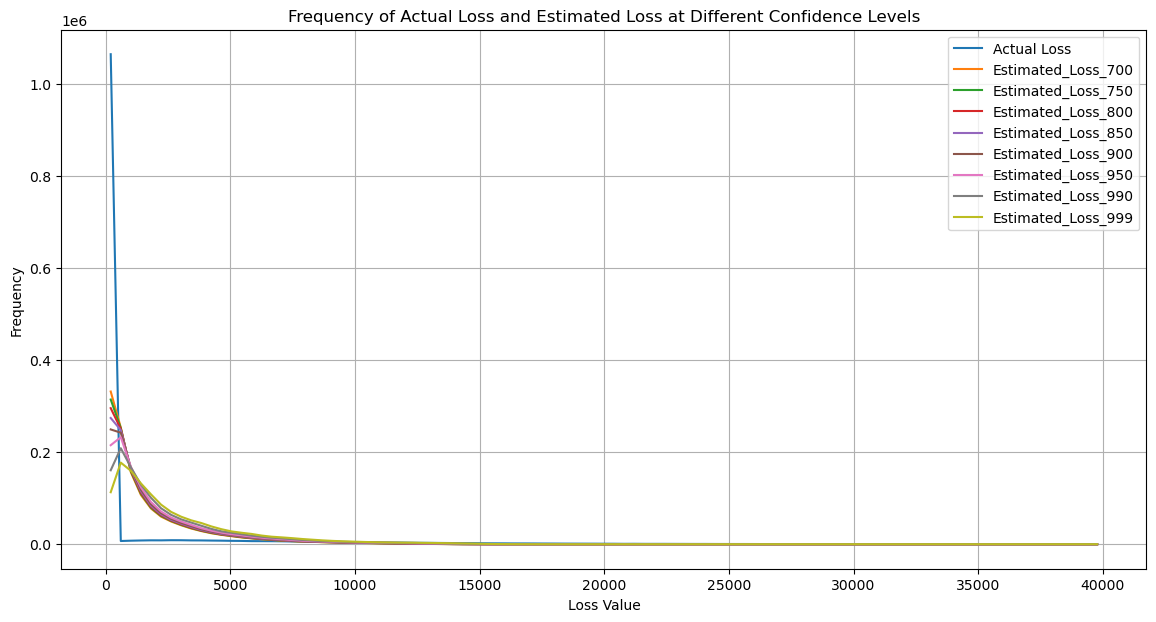

In [105]:
import matplotlib.pyplot as plt
import numpy as np

# Define the columns to plot
loss_columns = {
    'loss': 'Actual Loss',
    'Estimated_Loss_700': 'Estimated_Loss_700',
    'Estimated_Loss_750': 'Estimated_Loss_750',   
    'Estimated_Loss_800': 'Estimated_Loss_800',
    'Estimated_Loss_850': 'Estimated_Loss_850',
    'Estimated_Loss_900': 'Estimated_Loss_900',
    'Estimated_Loss_950': 'Estimated_Loss_950',
    'Estimated_Loss_990': 'Estimated_Loss_990',
    'Estimated_Loss_999': 'Estimated_Loss_999'
}

# Check and remove any columns not in DataFrame
loss_columns = {k: v for k, v in loss_columns.items() if k in df_f_vasicek_final.columns}

# Plot histogram lines
plt.figure(figsize=(14, 7))

# Determine bin edges for all histograms to align the bins
bins = np.linspace(
    min(df_f_vasicek_final[list(loss_columns.keys())].min()), 
    max(df_f_vasicek_final[list(loss_columns.keys())].max()), 
    100
)

# Plot a line for each specified column
for column, label in loss_columns.items():
    hist_values, _ = np.histogram(df_f_vasicek_final[column], bins=bins)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    plt.plot(bin_centers, hist_values, label=label)

plt.xlabel('Loss Value')
plt.ylabel('Frequency')
plt.title('Frequency of Actual Loss and Estimated Loss at Different Confidence Levels')
plt.legend()
plt.grid(True)
plt.show()


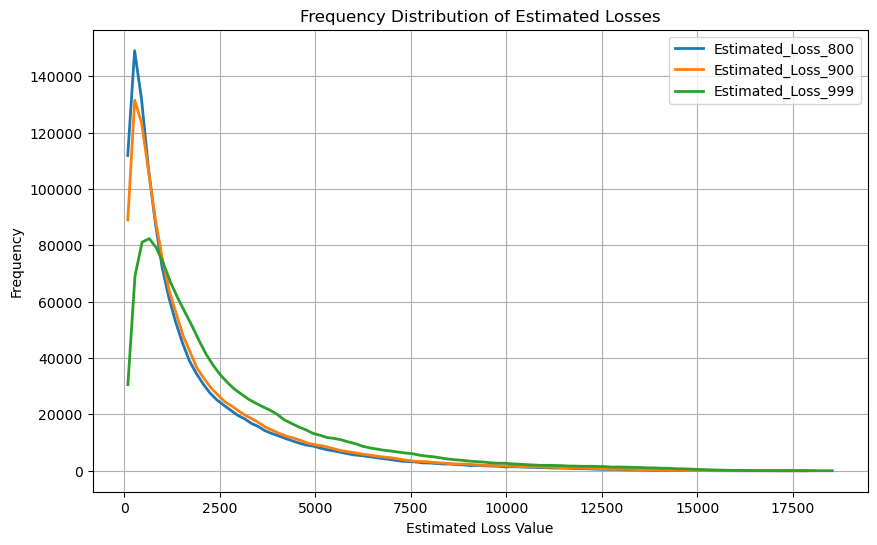

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is your DataFrame and it contains the specified columns
columns = [
    'Estimated_Loss_800',
   
    'Estimated_Loss_900',
   
    
    'Estimated_Loss_999'
]

# Create a figure for the histograms
plt.figure(figsize=(10, 6))

# Loop over the column names and plot a histogram for each
for column in columns:
    # Calculate histogram values and bins without probability density (i.e., frequency)
    hist_values, bin_edges = np.histogram(df_f_vasicek_final[column], bins=100, density=False)

    # Calculate the bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Plot the histogram (frequency)
    plt.plot(bin_centers, hist_values, label=f'{column}', linewidth=2)

# Add labels and title
plt.xlabel('Estimated Loss Value')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Estimated Losses')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


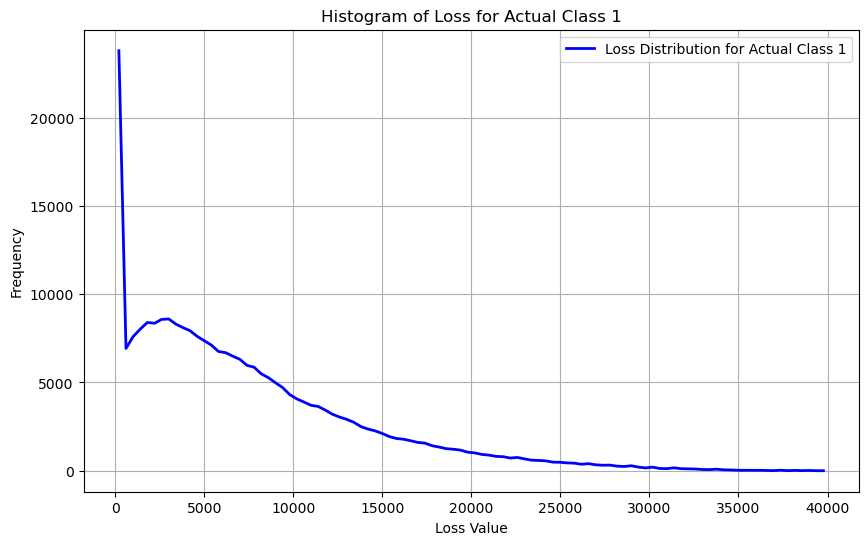

In [99]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for 'actual_class' equals 1
filtered_df = df_f_v_final[df_f_vasicek_final['actual_class'] == 1]

# Calculate histogram values and bins for the 'loss' column
hist_values, bins = np.histogram(filtered_df['loss'], bins=100)

# Calculate the bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Plot the line plot for histogram
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, hist_values, label='Loss Distribution for Actual Class 1', linewidth=2, color='blue')

plt.xlabel('Loss Value')
plt.ylabel('Frequency')
plt.title('Histogram of Loss for Actual Class 1')
plt.legend()
plt.grid(True)
plt.show()


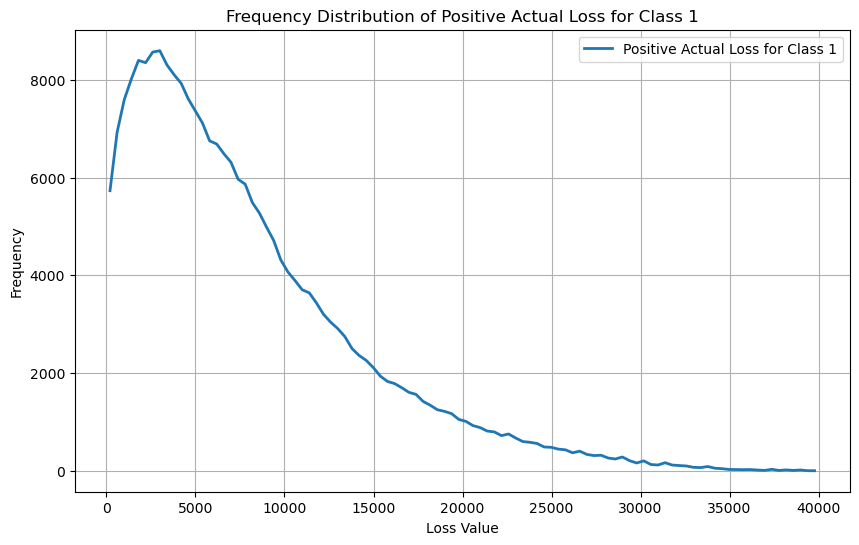

In [100]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for 'loss' values greater than 0 and 'actual_class' equals 1
filtered_df = df_f_vasicek_final[(df_f_vasicek_final['loss'] > 0) & (df_f_v_final['actual_class'] == 1)]

# Calculate histogram values and bins without probability density (i.e., frequency)
hist_values, bin_edges = np.histogram(filtered_df['loss'], bins=100, density=False)

# Calculate the bin centers
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Plot histogram for the 'loss' column with positive values and actual_class == 1
plt.figure(figsize=(10, 6))

# Plot the line plot for histogram (frequency)
plt.plot(bin_centers, hist_values, label='Positive Actual Loss for Class 1', linewidth=2)

plt.xlabel('Loss Value')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Positive Actual Loss for Class 1')
plt.legend()
plt.grid(True)
plt.show()


In [106]:
import pandas as pd
import numpy as np

# Assuming df_f_v_final is your DataFrame and is already loaded

# Group the DataFrame by 'issue_year' and 'issue_month'
grouped = df_f_vasicek_final.groupby(['issue_year', 'issue_month'])

# Initialize a dictionary to store results
results = {
    'loss': [],
    'Estimated_Loss_700': [],
    'Estimated_Loss_750': [], 
    'Estimated_Loss_800': [],
    'Estimated_Loss_850': [],
    'Estimated_Loss_900': [],
    'Estimated_Loss_950': [],
    'Estimated_Loss_990': [],
    'Estimated_Loss_999': []
}

# Calculate sums for each group
for name, group in grouped:
    for key in results.keys():
        results[key].append(group[key].sum())

# Convert to DataFrame for easier comparison
results_df = pd.DataFrame(results, index=grouped.size().index.rename(['Year', 'Month']))

# Frequency of actual loss sum exceeding estimated loss sums
frequencies = {}
for col in results_df.columns[1:]:  # Skip the first column which is 'loss'
    frequencies[col] = np.sum(results_df['loss'] > results_df[col])

frequencies


{'Estimated_Loss_700': 26,
 'Estimated_Loss_750': 25,
 'Estimated_Loss_800': 19,
 'Estimated_Loss_850': 18,
 'Estimated_Loss_900': 17,
 'Estimated_Loss_950': 14,
 'Estimated_Loss_990': 10,
 'Estimated_Loss_999': 0}

In [107]:
# Group the DataFrame by 'issue_year' and 'issue_month'
grouped_counts = df_f_vasicek_final.groupby(['issue_year']).size()

# Convert the result to a DataFrame for easier reading
counts_df = grouped_counts.reset_index(name='Count')

# Display the DataFrame
counts_df


,issue_year,Count
0,2012,53308
1,2013,134710
2,2014,222951
3,2015,375321
4,2016,292729
5,2017,168759
6,2018,55741


In [108]:
import pandas as pd

# Assuming df_f_vasicek_final is already loaded in your environment

# List of columns to calculate the sum
columns_to_sum = [
    'loss',
    'Estimated_Loss_700',
    'Estimated_Loss_750',
    'Estimated_Loss_800',
    'Estimated_Loss_850',
    'Estimated_Loss_900',
    'Estimated_Loss_950',
    'Estimated_Loss_990',
    'Estimated_Loss_999'
]

# Calculate the sums
sums = df_f_vasicek_final[columns_to_sum].sum()

# Convert the series to a DataFrame for nicer display, and transpose it
sum_matrix = pd.DataFrame(sums).transpose()

# Rename index to 'Total Sum' for better understanding
sum_matrix.index = ["Total Sum"]

# Display the DataFrame
print(sum_matrix)


                   loss  Estimated_Loss_700  Estimated_Loss_750  \
Total Sum  1.944285e+09        2.335443e+09        2.405126e+09   

           Estimated_Loss_800  Estimated_Loss_850  Estimated_Loss_900  \
Total Sum        2.483934e+09        2.577370e+09        2.697264e+09   

           Estimated_Loss_950  Estimated_Loss_990  Estimated_Loss_999  
Total Sum        2.879519e+09        3.234756e+09        3.650383e+09  


In [4]:
import numpy as np
from scipy.stats import chi2

# Total number of trials (days)
n = 84
# Observed number of exceedances for each confidence level
{'Estimated_Loss_700': 26,
 'Estimated_Loss_750': 25,
 'Estimated_Loss_800': 19,
 'Estimated_Loss_850': 18,
 'Estimated_Loss_900': 17,
 'Estimated_Loss_950': 14,
 'Estimated_Loss_990': 10,
 'Estimated_Loss_999': 0}

# Calculate Kupiec's test statistic and p-value for each confidence level
results = {}
for level, exceptions in exceedances.items():
    # Extract the numeric value from the level key
    confidence_percentage = int(level.split('_')[-1])
    # Calculate p from the confidence percentage
    p = (1000 - confidence_percentage) / 1000
    
    # Handle edge cases for log calculations
    p = max(p, 1e-10)  # prevent log(0)
    q = 1 - p
    q = max(q, 1e-10)  # prevent log(0)
    proportion = exceptions / n
    proportion = max(proportion, 1e-10)  # prevent log(0)
    one_minus_proportion = 1 - proportion
    one_minus_proportion = max(one_minus_proportion, 1e-10)  # prevent log(0)
    
    # Compute the components for the Kupiec test
    ln_part_model = (n - exceptions) * np.log(q) + exceptions * np.log(p)
    ln_part_actual = (n - exceptions) * np.log(one_minus_proportion) + exceptions * np.log(proportion)
    test_statistic = -2 * (ln_part_model - ln_part_actual)
    
    # Calculate the p-value
    p_value = chi2.sf(test_statistic, 1)  # survival function for chi-squared distribution

    # Store the results
    results[level] = {
        'Test Statistic': test_statistic,
        'p-value': p_value,
        'Model Accepted': p_value > 0.05
    }

results





{'Estimated_Loss_700': {'Test Statistic': 0.0360663166666626,
  'p-value': 0.8493786069630354,
  'Model Accepted': True},
 'Estimated_Loss_750': {'Test Statistic': 0.9771900239129252,
  'p-value': 0.32289353000655885,
  'Model Accepted': True},
 'Estimated_Loss_800': {'Test Statistic': 0.3491064324239517,
  'p-value': 0.5546193933310273,
  'Model Accepted': True},
 'Estimated_Loss_850': {'Test Statistic': 2.459405175671421,
  'p-value': 0.11682301443739536,
  'Model Accepted': True},
 'Estimated_Loss_900': {'Test Statistic': 7.787044750570388,
  'p-value': 0.005262219995925805,
  'Model Accepted': False},
 'Estimated_Loss_950': {'Test Statistic': 15.367281784229647,
  'p-value': 8.850765312555994e-05,
  'Model Accepted': False},
 'Estimated_Loss_990': {'Test Statistic': 32.26696687450138,
  'p-value': 1.3437852988280997e-08,
  'Model Accepted': False},
 'Estimated_Loss_999': {'Test Statistic': 0.16808403924203238,
  'p-value': 0.6818202262657833,
  'Model Accepted': True}}

In [3]:
from scipy.stats import chi2

# Calculate the critical chi-square value for 1% significance level
chi_squared_value_1_percent = chi2.ppf(0.99, df=1)  # df=1 for one degree of freedom
chi_squared_value_1_percent


6.6348966010212145